# **Importar librerias**

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
print("Version of Pandas:",pd.__version__)
print("Version of GeoPandas:",gpd.__version__)

Version of Pandas: 1.5.3
Version of GeoPandas: 0.13.2


# **Caracteristicas y carga de los datos**

In [2]:
# Cargar el DataFrame de los picos de rayos desde un archivo CSV
ruta_csv_picos_rayos = '/content/drive/MyDrive/2. TP Inteligencia Artificial/Datoss/Rayosfiltrados/2017_unificado.csv'
df = pd.read_csv(ruta_csv_picos_rayos)

In [3]:
# Tipos de datos
df.dtypes

type             int64
timestamp       object
latitude       float64
longitude      float64
peakcurrent    float64
dtype: object

In [4]:
# Tamaño del dataframe
df.shape

(9213809, 5)

In [5]:
# Primeras 5 filas
df.head()

,type,timestamp,latitude,longitude,peakcurrent
0,1,2017-01-01T00:00:02.766496897,-27.122080,-55.074393,11794.0
1,1,2017-01-01T00:00:05.431325912,-27.000504,-55.066179,-7435.0
2,1,2017-01-01T00:00:16.543782949,-27.030824,-54.910806,13410.0
3,0,2017-01-01T00:00:22.670992136,-27.168808,-54.564201,-17115.0
4,40,2017-01-01T00:00:23.228719950,-27.074800,-54.556200,-22988.0


In [6]:
# Buscar valores NaN
df.isna().value_counts()

type   timestamp  latitude  longitude  peakcurrent
False  False      False     False      False          9213808
                            True       True                 1
dtype: int64

In [8]:
# Valores NaN encontrados en la columna "longitude",
# Se reemplaza con la media
median = df["longitude"].median()
df['longitude'] = df['longitude'].fillna(median)

# Valores NaN encontrados en la columna "peakcurrent",
# Se reemplaza con la media
median = df["peakcurrent"].median()
df['peakcurrent'] = df['peakcurrent'].fillna(median)

In [10]:
# Verificando que el dataframe esté libre de valores Nan
df.isna().value_counts()

type   timestamp  latitude  longitude  peakcurrent
False  False      False     False      False          9213809
dtype: int64

In [11]:
# Generar estadísticas descriptivas

# DataFrame.count: Cuente el número de observaciones que no son NA/nulas.
# DataFrame.max:Máximo de los valores del objeto.
#DataFrame.min:Mínimo de los valores del objeto.
#DataFrame.mean: Media de los valores.
#DataFrame.std: Desviación estándar de las observaciones.

df.describe()

,type,latitude,longitude,peakcurrent
count,9.213809e+06,9.213809e+06,9.213809e+06,9.213809e+06
mean,6.324374e+00,-2.361786e+01,-5.764200e+01,-5.153033e+03
std,1.384201e+01,2.372986e+00,2.243437e+00,9.177522e+04
min,0.000000e+00,-2.758833e+01,-6.263755e+01,-1.542866e+08
25%,0.000000e+00,-2.561810e+01,-5.920661e+01,-1.732100e+04
50%,1.000000e+00,-2.383370e+01,-5.732137e+01,-8.496000e+03
75%,1.000000e+00,-2.151297e+01,-5.577687e+01,9.892000e+03
max,4.000000e+01,1.136000e+02,-5.425856e+01,4.685770e+05


# **Filtrar y crear un GeoDataFrame**

In [12]:
# El archivo shapefile Departamentos_Paraguay.shp está en el CRS EPSG:4674
# Se utilizará el sistema de coordenadas de referencia EPSG 4326, que es el sistema de
# coordenadas estándar de latitud-longitud utilizado comúnmente, también conocido como WGS 84

# Crear una GeoDataFrame a partir de latitud y longitud
geometry = [Point(lon, lat) for lon, lat in zip(df['longitude'], df['latitude'])]
gdf_points = gpd.GeoDataFrame(df, geometry=geometry, crs='EPSG:4326')

# Cargar los límites de los departamentos de Paraguay
departamentos_paraguay = gpd.read_file('/content/drive/MyDrive/2. TP Inteligencia Artificial/PAIS/Departamentos_Paraguay.shp')

# Reproyectar departamentos_paraguay al CRS EPSG:4326
departamentos_paraguay = departamentos_paraguay.to_crs(epsg=4326)

# Filtrar los puntos que están dentro de los departamentos
puntos_en_departamentos = gpd.sjoin(gdf_points, departamentos_paraguay, how='inner', op='within')

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


In [13]:
# Tamaño del geodataframe
puntos_en_departamentos.shape

(4680750, 9)

In [14]:
# Ver datos aleatorios
puntos_en_departamentos.head(800000)

,type,timestamp,latitude,longitude,peakcurrent,geometry,index_right,DPTO,DPTO_DESC
183,0,2017-01-01T00:10:14.806118488,-27.311944,-55.637377,-15372.0,POINT (-55.63738 -27.31194),7,07,ITAPÚA
800,1,2017-01-01T00:34:07.536481142,-26.937459,-55.167338,10467.0,POINT (-55.16734 -26.93746),7,07,ITAPÚA
1045,40,2017-01-01T00:41:55.345834017,-27.303600,-56.265100,-27092.0,POINT (-56.26510 -27.30360),7,07,ITAPÚA
1213,40,2017-01-01T00:47:34.570938110,-27.397300,-56.729700,20780.0,POINT (-56.72970 -27.39730),7,07,ITAPÚA
1229,40,2017-01-01T00:48:21.808492899,-27.366200,-55.720100,-20842.0,POINT (-55.72010 -27.36620),7,07,ITAPÚA
...,...,...,...,...,...,...,...,...,...
5211396,0,2017-10-08T07:39:45.577629089,-24.926930,-54.991555,-19600.0,POINT (-54.99155 -24.92693),10,10,ALTO PARANÁ
5211398,1,2017-10-08T07:39:46.803402662,-24.880492,-55.229555,16497.0,POINT (-55.22955 -24.88049),10,10,ALTO PARANÁ
5211408,1,2017-10-08T07:40:13.253187895,-24.724357,-54.781883,27666.0,POINT (-54.78188 -24.72436),10,10,ALTO PARANÁ
5211412,1,2017-10-08T07:40:25.186083317,-24.717452,-54.770586,23674.0,POINT (-54.77059 -24.71745),10,10,ALTO PARANÁ


In [15]:
# Usar value_counts para contar la frecuencia de cada departamento
frecuencia_departamentos = puntos_en_departamentos['DPTO_DESC'].value_counts()
frecuencia_departamentos

PRESIDENTE HAYES    900029
ALTO PARAGUAY       734368
BOQUERÓN            463526
CANINDEYÚ           309827
SAN PEDRO           286851
ITAPÚA              281236
ALTO PARANÁ         263586
CONCEPCIÓN          218982
CAAGUAZÚ            202501
MISIONES            200788
ÑEEMBUCÚ            179594
CAAZAPÁ             176581
PARAGUARÍ           147461
AMAMBAY             144926
CORDILLERA           72614
GUAIRÁ               59384
CENTRAL              37012
ASUNCIÓN              1484
Name: DPTO_DESC, dtype: int64

#**Gráfica de cantidad de rayos por departamento**

In [20]:
# Mapclassify es una biblioteca de Python útil con datos geoespaciales
# para clasificarlos en diferentes clases para realizar análisis más avanzados o visualizaciones

In [19]:
pip install mapclassify

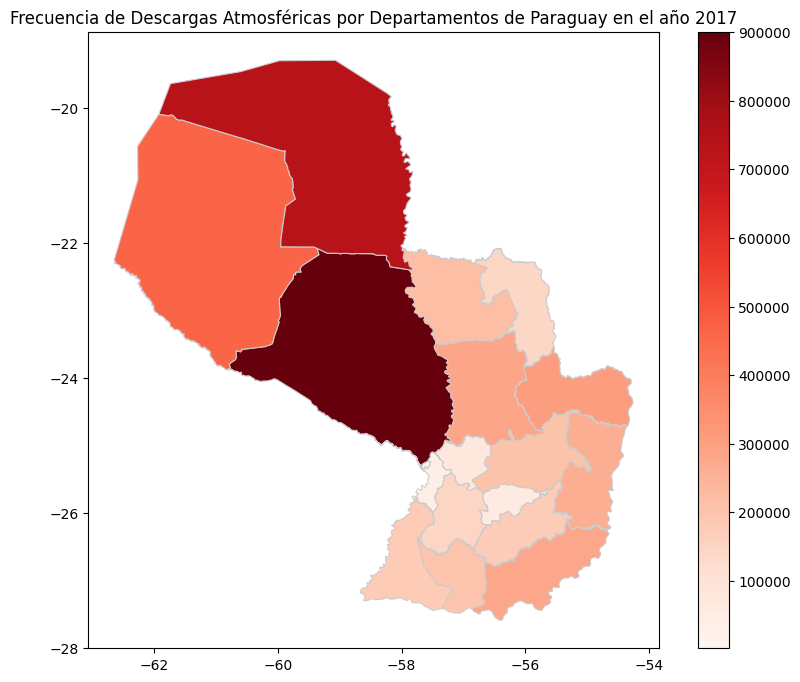

In [21]:
# Cargar el mapa de Paraguay
paraguay = gpd.read_file('/content/drive/MyDrive/2. TP Inteligencia Artificial/PAIS/Departamentos_Paraguay.shp')

# Obtener los valores únicos de la columna 'DPTO_DESC' en el orden correcto
departamentos_ordenados = paraguay['DPTO_DESC'].unique()

# Calcular la frecuencia de departamentos
frecuencia_departamentos = puntos_en_departamentos['DPTO_DESC'].value_counts()

# Reordenar los índices del DataFrame frecuencia_departamentos
frecuencia_departamentos = frecuencia_departamentos.reindex(departamentos_ordenados)

# Combinar la información de frecuencia con el mapa de Paraguay
paraguay = paraguay.merge(frecuencia_departamentos, left_on='DPTO_DESC', right_index=True, how='left')

# Graficar el mapa
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
paraguay.plot(column='DPTO_DESC_y', cmap='Reds', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
plt.title('Frecuencia de Descargas Atmosféricas por Departamentos de Paraguay en el año 2017')
plt.show()

# **Separar datos por departamento**

**Crear nuevos DataFrames separados por departamento. Esto permitirá analizar y visualizar las tendencias de cada departamento de manera independiente**

In [24]:
# Convertir la columna 'timestamp' en formato fecha
puntos_en_departamentos['fecha'] = pd.to_datetime(puntos_en_departamentos['timestamp'])

In [25]:
# Agrupar los datos por departamento
datos_por_departamento = dict(tuple(puntos_en_departamentos.groupby('DPTO_DESC')))

# Crear un nuevo DataFrame para cada departamento
dfs_por_departamento = {}
for departamento, grupo in datos_por_departamento.items():
    dfs_por_departamento[departamento] = grupo.set_index('fecha')['peakcurrent']

In [101]:
# Acceder a los datos de un departamento específico
# Pasar a ser datos pd.series
datos_asuncion = dfs_por_departamento['ASUNCIÓN']
datos_concepcion = dfs_por_departamento['CONCEPCIÓN']
datos_sanpedro = dfs_por_departamento['SAN PEDRO']
datos_cordillera = dfs_por_departamento['CORDILLERA']
datos_guaira = dfs_por_departamento['GUAIRÁ']
datos_caaguazu = dfs_por_departamento['CAAGUAZÚ']
datos_caazapa = dfs_por_departamento['CAAZAPÁ']
datos_itapua = dfs_por_departamento['ITAPÚA']
datos_misiones = dfs_por_departamento['MISIONES']
datos_paraguari = dfs_por_departamento['PARAGUARÍ']
datos_altoparana = dfs_por_departamento['ALTO PARANÁ']
datos_central = dfs_por_departamento['CENTRAL']
datos_neembucu = dfs_por_departamento['ÑEEMBUCÚ']
datos_amambay = dfs_por_departamento['AMAMBAY']
datos_canindeyu = dfs_por_departamento['CANINDEYÚ']
datos_presidentehayes = dfs_por_departamento['PRESIDENTE HAYES']
datos_boqueron = dfs_por_departamento['BOQUERÓN']
datos_altoparaguay = dfs_por_departamento['ALTO PARAGUAY']

# **Gráfica de la serie temporal por departamento**

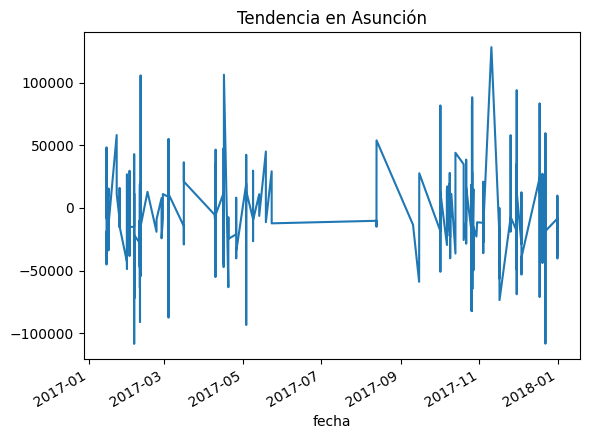

In [27]:
# Graficar la tendencia de Asunción
datos_asuncion.plot()
plt.title('Tendencia en Asunción')
plt.show()

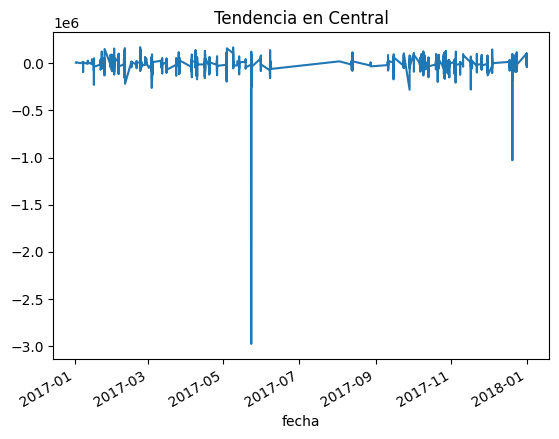

In [28]:
# Graficar la tendencia de Central
datos_central.plot()
plt.title('Tendencia en Central')
plt.show()

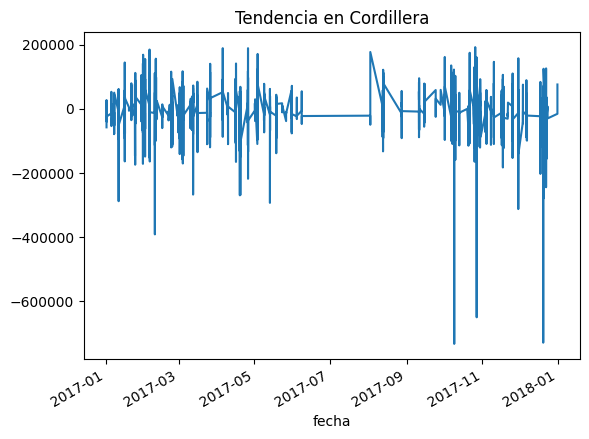

In [29]:
# Graficar la tendencia de Cordillera
datos_cordillera.plot()
plt.title('Tendencia en Cordillera')
plt.show()

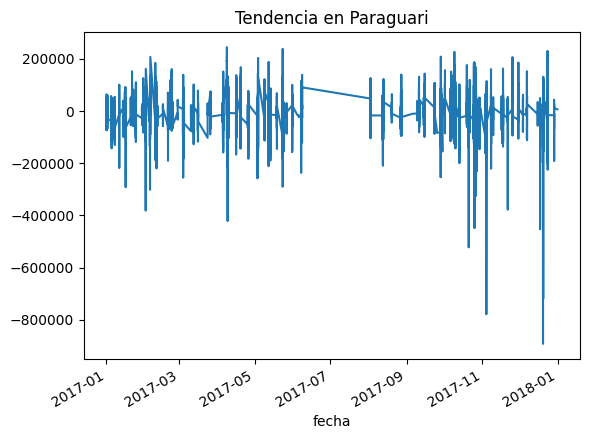

In [30]:
# Graficar la tendencia de Paraguari
datos_paraguari.plot()
plt.title('Tendencia en Paraguari')
plt.show()

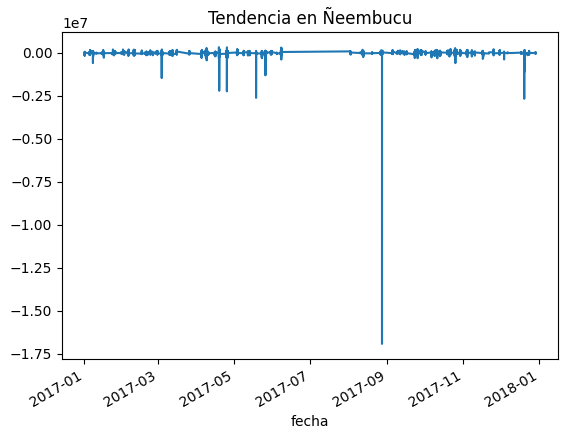

In [31]:
# Graficar la tendencia de Ñeembucu
datos_neembucu.plot()
plt.title('Tendencia en Ñeembucu')
plt.show()

In [73]:
# datos_presidentehayes es un pd.Series
valor_minimo = datos_neembucu.min()

# Crear un nuevo pd.Series sin el valor mínimo
nuevo_series = datos_neembucu[datos_neembucu != valor_minimo]

# Reemplazar en la serie original
datos_neembucu = nuevo_series

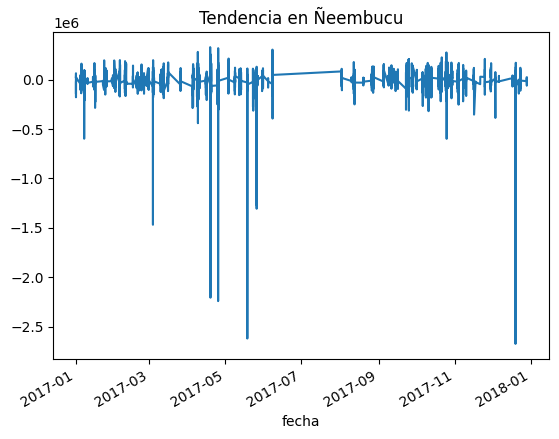

In [74]:
# Graficar la tendencia de Ñeembucu
datos_neembucu.plot()
plt.title('Tendencia en Ñeembucu')
plt.show()

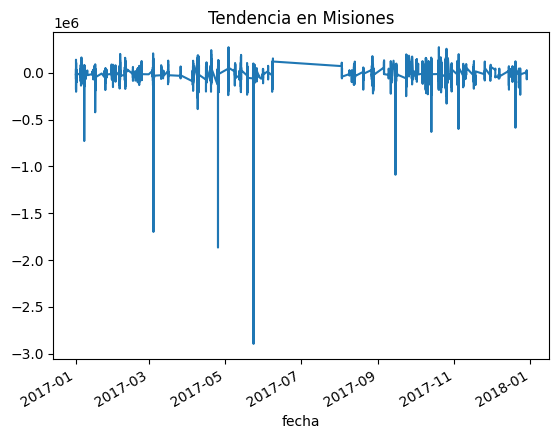

In [32]:
# Graficar la tendencia de Misiones
datos_misiones.plot()
plt.title('Tendencia en Misiones')
plt.show()

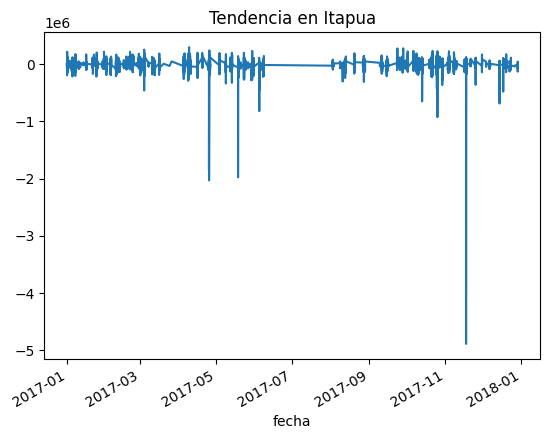

In [33]:
# Graficar la tendencia de Itapua
datos_itapua.plot()
plt.title('Tendencia en Itapua')
plt.show()

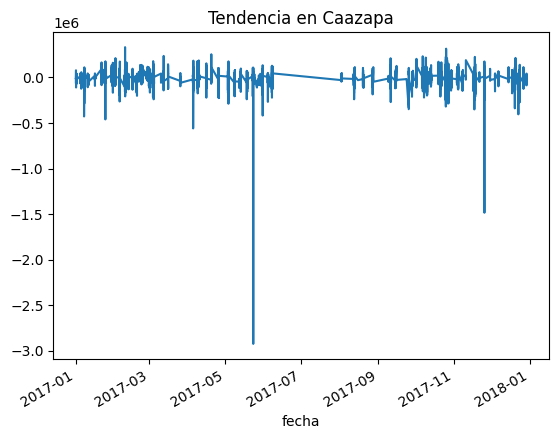

In [34]:
# Graficar la tendencia de Caazapa
datos_caazapa.plot()
plt.title('Tendencia en Caazapa')
plt.show()

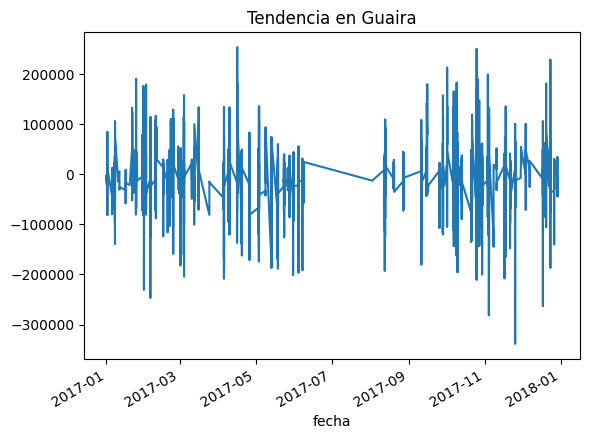

In [35]:
# Graficar la tendencia de Guaira
datos_guaira.plot()
plt.title('Tendencia en Guaira')
plt.show()

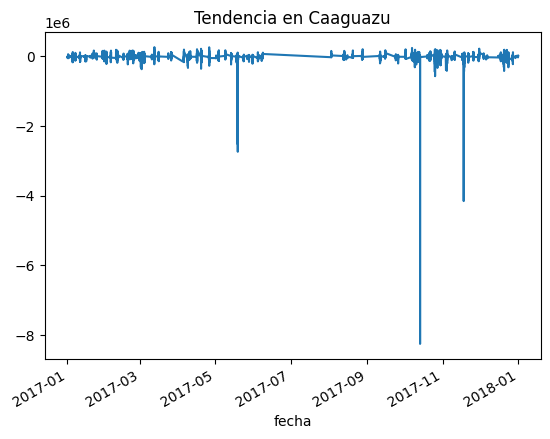

In [36]:
# Graficar la tendencia de Caaguazu
datos_caaguazu.plot()
plt.title('Tendencia en Caaguazu')
plt.show()

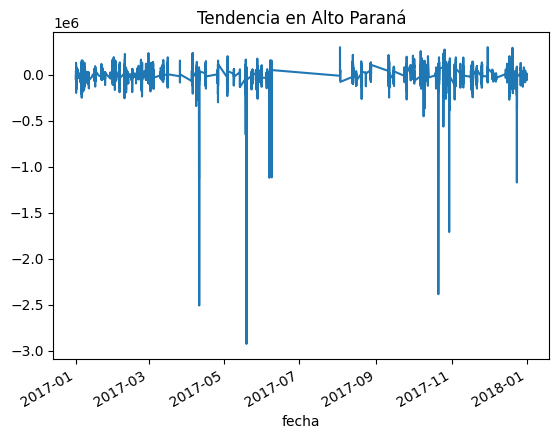

In [37]:
# Graficar la tendencia de Alto Paraná
datos_altoparana.plot()
plt.title('Tendencia en Alto Paraná')
plt.show()

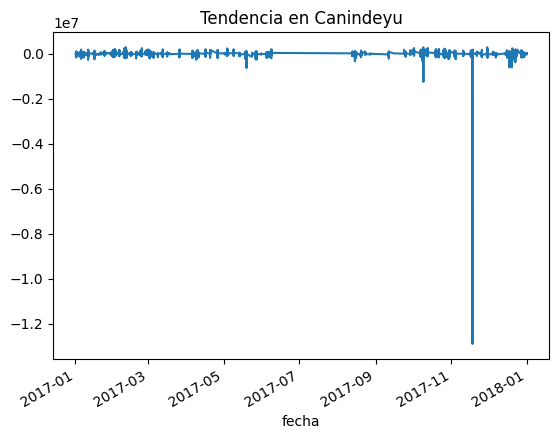

In [38]:
# Graficar la tendencia de Canindeyu
datos_canindeyu.plot()
plt.title('Tendencia en Canindeyu')
plt.show()

In [75]:
# datos_presidentehayes es un pd.Series
valor_minimo = datos_canindeyu.min()

# Crear un nuevo pd.Series sin el valor mínimo
nuevo_series = datos_canindeyu[datos_canindeyu != valor_minimo]

# Reemplazar en la serie original
datos_canindeyu = nuevo_series

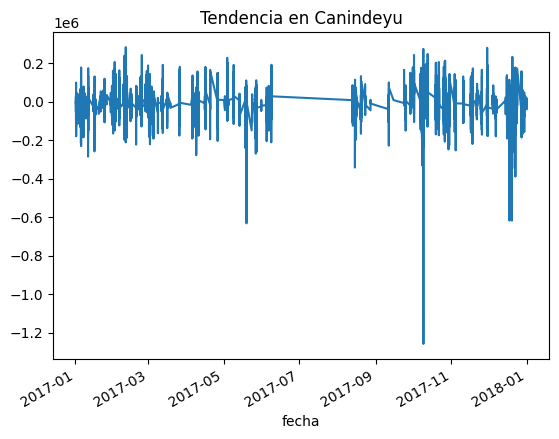

In [76]:
# Graficar la tendencia de Canindeyu
datos_canindeyu.plot()
plt.title('Tendencia en Canindeyu')
plt.show()

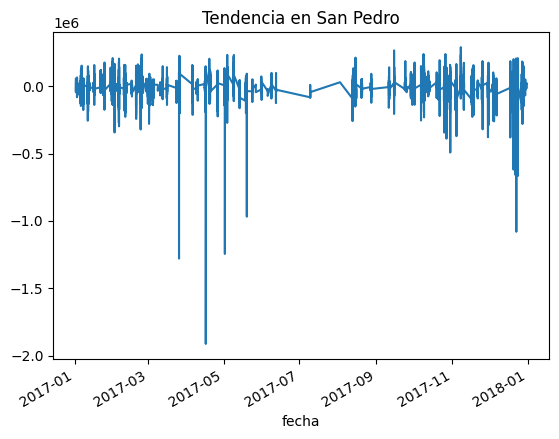

In [39]:
# Graficar la tendencia de San Pedro
datos_sanpedro.plot()
plt.title('Tendencia en San Pedro')
plt.show()

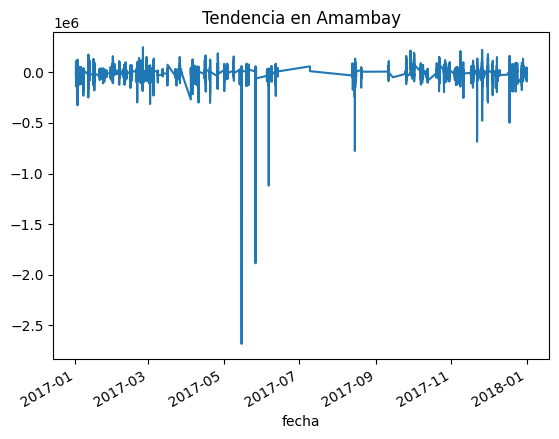

In [40]:
# Graficar la tendencia de Amambay
datos_amambay.plot()
plt.title('Tendencia en Amambay')
plt.show()

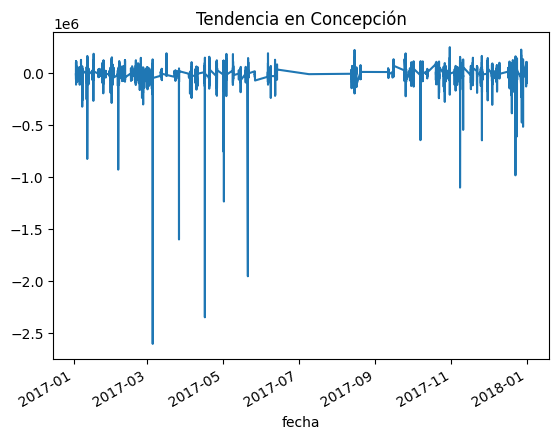

In [41]:
# Graficar la tendencia de Concepción
datos_concepcion.plot()
plt.title('Tendencia en Concepción')
plt.show()

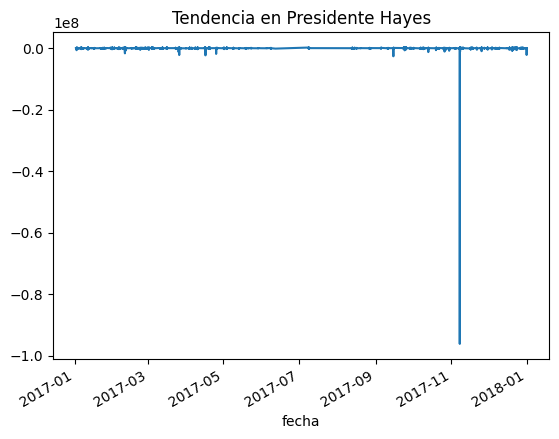

In [42]:
# Graficar la tendencia de Presidente Hayes
datos_presidentehayes.plot()
plt.title('Tendencia en Presidente Hayes')
plt.show()

In [64]:
# datos_presidentehayes es un pd.Series
valor_minimo = datos_presidentehayes.min()

# Crear un nuevo pd.Series sin el valor mínimo
nuevo_series = datos_presidentehayes[datos_presidentehayes != valor_minimo]

# Reemplazar en la serie original
datos_presidentehayes = nuevo_series

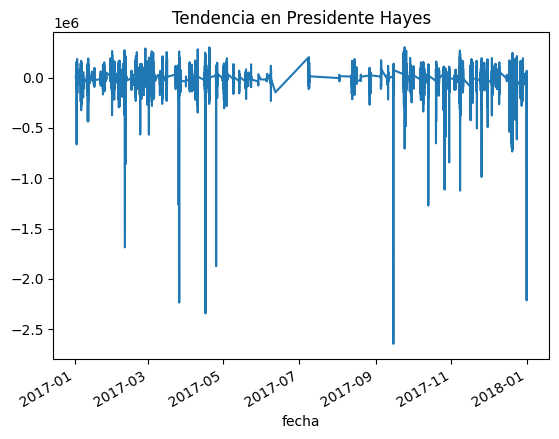

In [65]:
# Graficar la tendencia de Presidente Hayes
datos_presidentehayes.plot()
plt.title('Tendencia en Presidente Hayes')
plt.show()

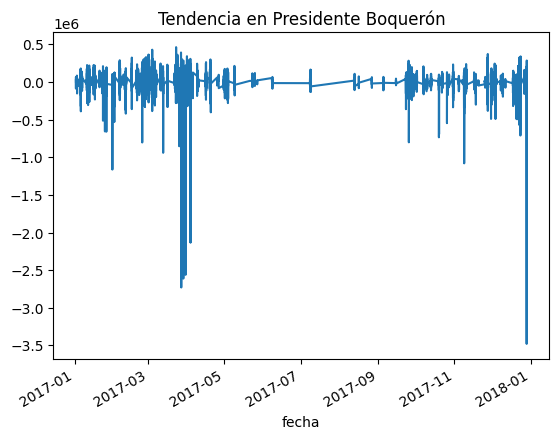

In [66]:
# Graficar la tendencia de Boquerón
datos_boqueron.plot()
plt.title('Tendencia en Presidente Boquerón')
plt.show()

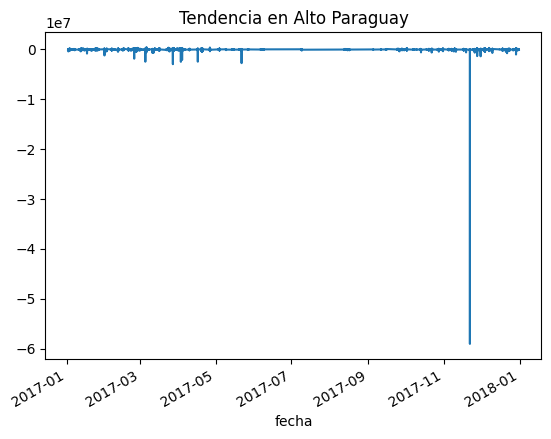

In [67]:
# Graficar la tendencia de Alto Paraguay
datos_altoparaguay.plot()
plt.title('Tendencia en Alto Paraguay')
plt.show()

In [71]:
# datos_presidentehayes es un pd.Series
valor_minimo = datos_altoparaguay.min()

# Crear un nuevo pd.Series sin el valor mínimo
nuevo_series = datos_altoparaguay[datos_altoparaguay != valor_minimo]

# Reemplazar en la serie original
datos_altoparaguay = nuevo_series

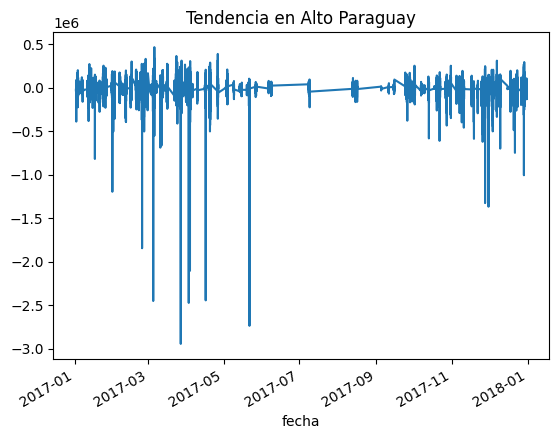

In [72]:
# Graficar la tendencia de Alto Paraguay
datos_altoparaguay.plot()
plt.title('Tendencia en Alto Paraguay')
plt.show()

# **Predicción en Asunción**

In [107]:
# Ajustar el modelo ARIMA
modelo_arima = ARIMA(datos_asuncion, order=(1,2,1))
# p: orden del componente autorregresivo (AR).
# d: orden de diferenciación, que indica cuántas veces se diferencia la serie temporal para hacerla estacionaria.
# q: orden del componente de media móvil (MA).

modelo_arima_entrenado = modelo_arima.fit()

# Generar una predicción
prediccion = modelo_arima_entrenado.predict(start=datos_asuncion.index.min(),
                                end=datos_asuncion.index.max(), typ='levels')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsm

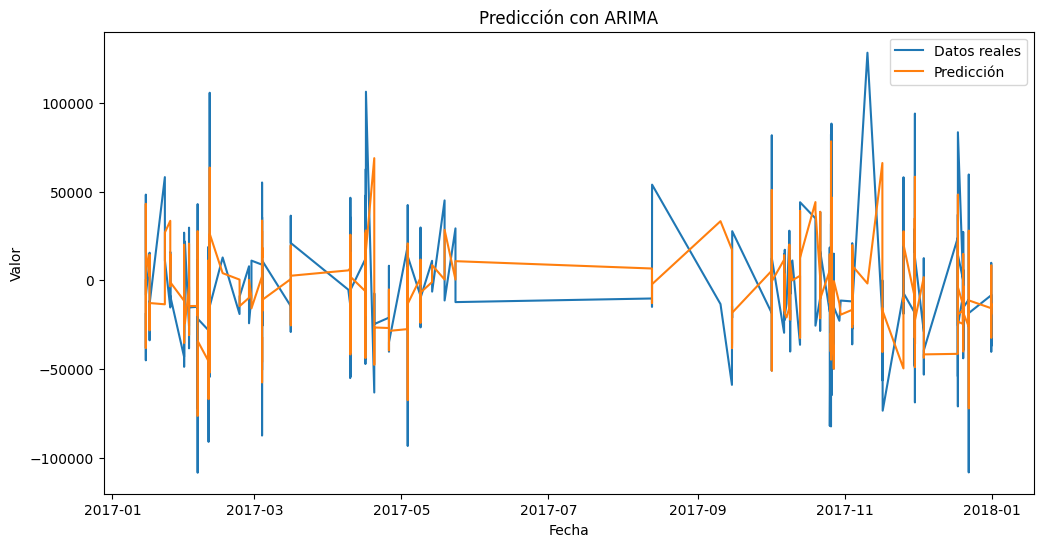

In [108]:
# Visualizar la predicción
plt.figure(figsize=(12, 6))
plt.plot(datos_asuncion, label='Datos reales')
plt.plot(prediccion.index, prediccion.values, label='Predicción')
plt.title('Predicción con ARIMA')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.show()

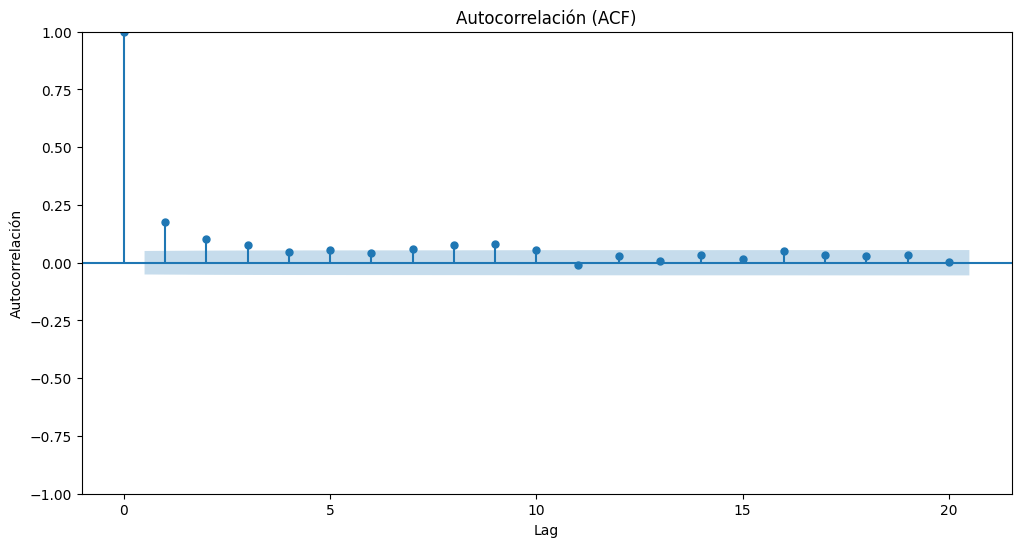

In [109]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Graficar el ACF
plt.figure(figsize=(12, 6))
plot_acf(datos_asuncion, lags=20, ax=plt.gca())
plt.title('Autocorrelación (ACF)')
plt.xlabel('Lag')
plt.ylabel('Autocorrelación')
plt.show()

# buscar los picos significativos que caen fuera del intervalo de confianza para
# identificar posibles valores de q

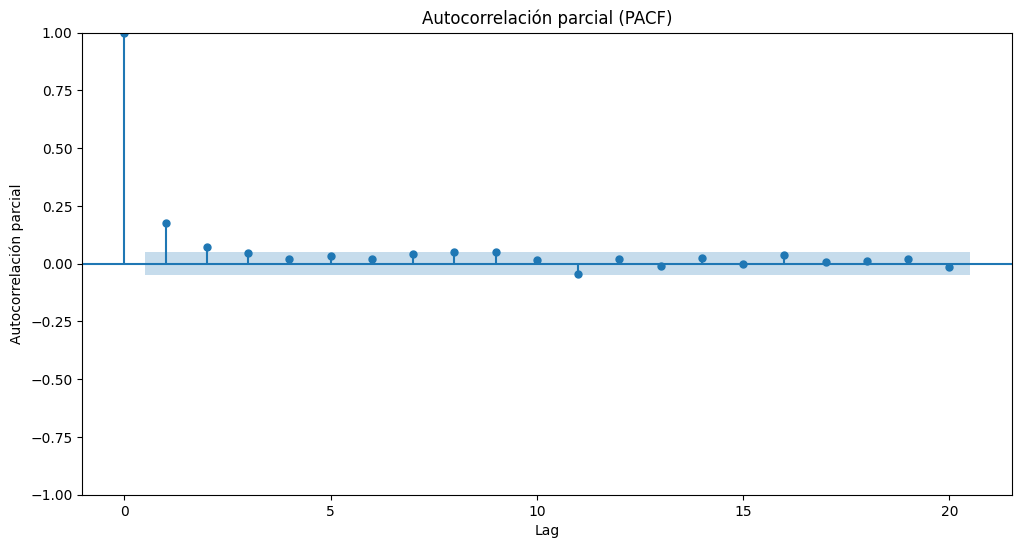

In [110]:
# Graficar el PACF
plt.figure(figsize=(12, 6))
plot_pacf(datos_asuncion, lags=20, ax=plt.gca())
plt.title('Autocorrelación parcial (PACF)')
plt.xlabel('Lag')
plt.ylabel('Autocorrelación parcial')
plt.show()

# buscar los picos significativos que caen fuera del intervalo de confianza para
# identificar posibles valores de p

In [111]:
# Ajustar varios modelos ARIMA con diferentes valores para p y q
resultados = []
for p in range(3):  # Prueba valores de p de 0 a 2
    for q in range(3):  # Prueba valores de q de 0 a 2
        try:
            modelo_arima = ARIMA(datos_asuncion, order=(p, 1, q))  # Se asume que se requiere una diferenciación para hacer la serie estacionaria
            modelo_arima_entrenado = modelo_arima.fit()
            aic = modelo_arima_entrenado.aic
            bic = modelo_arima_entrenado.bic
            resultados.append({'p': p, 'q': q, 'AIC': aic, 'BIC': bic})
        except:
            continue

# Convertir los resultados en un DataFrame para facilitar la comparación
resultados_df = pd.DataFrame(resultados)

# Mostrar los resultados ordenados por AIC o BIC
print("Resultados ordenados por AIC:")
print(resultados_df.sort_values(by='AIC'))
print("\nResultados ordenados por BIC:")
print(resultados_df.sort_values(by='BIC'))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsm

Resultados ordenados por AIC:
   p  q           AIC           BIC
5  1  2  33948.769656  33969.976945
8  2  2  33956.508910  33983.018022
2  0  2  33957.816577  33973.722044
7  2  1  33964.174468  33985.381758
4  1  1  33965.877334  33981.782801
1  0  1  33984.735740  33995.339385
6  2  0  34254.453113  34270.358580
3  1  0  34389.698649  34400.302294
0  0  0  34733.053767  34738.355589

Resultados ordenados por BIC:
   p  q           AIC           BIC
5  1  2  33948.769656  33969.976945
2  0  2  33957.816577  33973.722044
4  1  1  33965.877334  33981.782801
8  2  2  33956.508910  33983.018022
7  2  1  33964.174468  33985.381758
1  0  1  33984.735740  33995.339385
6  2  0  34254.453113  34270.358580
3  1  0  34389.698649  34400.302294
0  0  0  34733.053767  34738.355589
